# Bayesian Filtering and Smoothing in **nonlinear** state-space models with `probnum`
## Tutorial

Provided are two examples of nonlinear state-space models on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1] and [2].

We provide examples for two different types of state-space model:
1. [Nonlinear, Discrete State-Space Model](#1.-Non-Linear-Discrete-State-Space-Model:-Pendulum): Pendulum
2. [Nonlinear, Continuous-Discrete State-Space Model](#2.-Non-Linear-Continuous-Discrete-State-Space-Model:-Benes-Daum-Filter): Benes-Daum Filter

In order to perform Bayesian Filtering and Smoothing on non-linear models, we show how `probnum` provides easy-to-use functionalities to
either linearise the respective model (Extended Kalman Filter, EKF) or to use an Unscented Transform (Unscented Kalman Filter, UKF) which does not require a Jacobian of the nonlinear model.

**References**:
> [1] Särkkä, Simo, and Solin, Arno. Applied stochastic differential equations. Cambridge University Press, 2019.  
>
> [2] Särkkä, Simo. Bayesian filtering and smoothing. Cambridge University Press, 2013.

In [1]:
import numpy as np

import probnum as pn
import probnum.filtsmooth as pnfs
import probnum.random_variables as pnrv

In [2]:
np.random.seed(12345)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../../probnum.mplstyle')

# 1. **Non-Linear Discrete** State-Space Model: Pendulum
---

For nonlinear models, we assume that at least one of the components of our state-space model (i.e. either the dynamics, the measurement model, or both) is based on a non-linear function.
Consider non-linear functions $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $d$ is the dimension of the latent state and
$m$ is the dimension of the measurements.

$
\begin{align}
    \boldsymbol{x}_k &\sim \mathcal{N}(f(\boldsymbol{x}_{k-1}), \boldsymbol{Q}) \\
    \boldsymbol{y}_k &\sim \mathcal{N}(h(\boldsymbol{x}_k), \boldsymbol{R})
\end{align}
$

This defines a dynamics model that assumes a state $x_k$ in a **discrete** sequence of states arising from a nonlinear map of the previous state $x_{k-1}$ corrupted with additive Gaussian noise under a **process noise** covariance matrix $Q$.  
Similarly, the measurements $y_k$ are assumed to be nonlinear transformations of the latent state under additive Gaussian noise according to a **measurement noise** covariance $R$.
In the described case, we cannot use the Kalman Filtering equations since these assume linear relationships. One method is to linearise the nonlinear parts of the model by a first-order Taylor Expansion (Extended Kalman Filter, EKF) or employing the Unscented Kalman Filter (UKF) which is based on the unscented transform and does not require the computation of a Jacobian.
The `probnum` packages provides both methods by wrapping linearizing "Components" around nonlinear dynamcis and/or measurement models, as we will see below.

Note that this can be generalized to a nonlinear time-varying state-space model, as well. Then we would have $f: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $\mathbb{T}$ is the "time dimension".

## Define State-Space Model

### I. Discrete, **Non-**Linear Dynamics Model

In [4]:
state_dim = 2
observation_dim = 1

In [5]:
# approx. gravitational constant
g = 9.81
# dt
delta_t = 0.0075

def pendulum_rhs(state):
    """Right-hand side of an ODE that defines pendulum dynamics"""
    x1, x2 = state
    y1 = x1 + x2 * delta_t
    y2 = x2 - g * np.sin(x1) * delta_t
    return np.array([y1, y2])

def pendulum_jacobian(state):
    """Jacobian of the pendulum ODE"""
    x1, x2 = state
    dy1_dx = [1.0, delta_t]
    dy2_dx = [-g * np.cos(x1) * delta_t, 1.0]
    return np.array([dy1_dx, dy2_dx])

dynamics_transition_function = lambda t, state: pendulum_rhs(state)
dynamics_transition_jacobian_function = lambda t, state: pendulum_jacobian(state)

dynamics_diffusion_matrix = 1.0 * (
    np.diag(np.array([delta_t ** 3 / 3, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2]), 1)
    + np.diag(np.array([delta_t ** 2 / 2]), -1)
)

We here define the non-linear dynamics of a pendulum. Note (in the cell directly above) that `probnum` expects `dynamicsfun` to be a function of time and state. Even though we here consider a nonlinear but time-**in**variant model, we still have to fulfill the contract that the interface requires. 
```python
dynamics_transition_function = lambda t, state: pendulum_rhs(state)
```
In other words, we simply ignore the time variable `t` in case of time-invariant models.

In [6]:
# Create discrete, non-linear Gaussian dynamics model
dynamics_model = pnfs.statespace.DiscreteGaussian(
    dynamicsfun=dynamics_transition_function, 
    diffmatfun=lambda t: dynamics_diffusion_matrix,
    jacobfun=dynamics_transition_jacobian_function
)

### II. Discrete, **Non-**Linear Measurement Model

In [7]:
def pendulum_measurement(state):
    x1, x2 = state
    return np.array([np.sin(x1)])

def pendulum_measurement_jacobian(state):
    x1, x2 = state
    return np.array([[np.cos(x1), 0.0]])

measurement_function = lambda t, state: pendulum_measurement(state)
measurement_jacobian_function = lambda t, state: pendulum_measurement_jacobian(state)

measurement_variance = 0.32 ** 2
measurement_covariance = measurement_variance * np.eye(observation_dim)

In [8]:
# Create discrete, non-linear Gaussian measurement model
measurement_model = pnfs.statespace.DiscreteGaussian(
    dynamicsfun=measurement_function, 
    diffmatfun=lambda t: measurement_covariance,
    jacobfun=measurement_jacobian_function
)

### III. Initial State Random Variable

In [9]:
mu_0 = np.ones(state_dim)
sigma_0 = measurement_variance * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [10]:
time_grid = np.arange(0., 20., step=delta_t)

In [11]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Linearize model (Extended Kalman Filter)

Since we could easily derive the Jacobian of our nonlinear model components above, we can use the Extended Kalman Filter (EKF) to obtain a filtering posterior over the states. Therefore, in `probnum` we just wrap the dynamics model and the measurement model in a `DiscreteEKFComponent` object.

In [12]:
linearised_dynamics_model = pnfs.DiscreteEKFComponent(dynamics_model)
linearised_measurement_model = pnfs.DiscreteEKFComponent(measurement_model)

### II. Kalman Filter

Then, we simply pass these linearized models to the Kalman Filter (exactly the same interface as in the linear case) and proceed.

In [13]:
kalman_filter = pnfs.Kalman(
    dynamics_model=linearised_dynamics_model,
    measurement_model=linearised_measurement_model,
    initrv=initial_state_rv
)

### III. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [14]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [15]:
posterior_state_rvs = state_posterior.state_rvs       # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov        # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

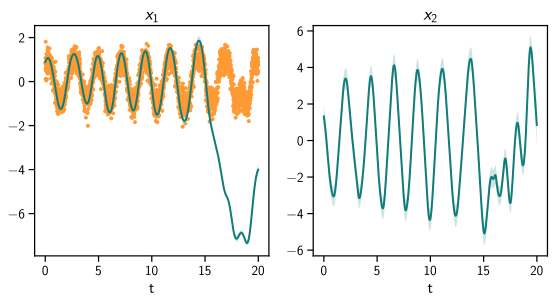

In [16]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=1, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])

# Plot means
mu_x_1, mu_x_2 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1);
ax_01.plot(time_grid, mu_x_2);

# Plot marginal standard deviations
std_x_1, std_x_2 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(time_grid, mu_x_1 - 1.96 * std_x_1,  mu_x_1 + 1.96 * std_x_1, alpha=0.2);
ax_01.fill_between(time_grid, mu_x_2 - 1.96 * std_x_2,  mu_x_2 + 1.96 * std_x_2, alpha=0.2);

# Plot groundtruth

ax_00.scatter(time_grid[1:], observations, marker=".");

# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")

state_fig.tight_layout()

# 2. **Non-Linear Continuous-Discrete** State-Space Model: Benes-Daum Filter
---

Now, consider we assume **continuous** dynamics. We assume that there is a continuous process that defines the nonlinear dynamics of our latent space from which we collect discrete nonlinear-Gaussian measurements (as above). Only the dynamics model changes. In particular, we formulate the dynamics as a stochastic process in terms of a Nonlinear Time-Invariant Stochastic Differential Equation. We refer to [1] for more details.
Again, consider non-linear functions $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $d$ is the dimension of the latent state and
$m$ is the dimension of the measurements.

We define the following nonlinear **continuous-discrete** state-space model:

$
\begin{align}
    d\boldsymbol{x} &= f(\boldsymbol{x}) \, dt + \boldsymbol{L} \, d \boldsymbol{\omega} \\
    \boldsymbol{y}_k &\sim \mathcal{N}(h(\boldsymbol{x}_k), \boldsymbol{R})
\end{align}
$

where $\boldsymbol{\omega}$ denotes a vector of driving forces (often Brownian Motion).


Note that this can be generalized to a nonlinear time-varying state-space model, as well. Then we would have $f: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $\mathbb{T}$ is the "time dimension".

## Define State-Space Model

### I. Continuous, **Non-**Linear Dynamics Model

In [17]:
state_dim = 1
observation_dim = 1

In [18]:
drift_function = lambda t, state: np.tanh(state)
drift_function_jacobian = lambda t, state: 1.0 - np.tanh(state)**2

dispersion_matrix_function = lambda t: np.ones(state_dim)


In [19]:
# Create continuous, non-linear SDE dynamics model
dynamics_model = pnfs.statespace.SDE(
    driftfun=drift_function, 
    dispmatfun=dispersion_matrix_function,
    jacobfun=drift_function_jacobian
)

### II. Discrete, Linear Measurement Model

In [20]:
measurement_marginal_variance = 1.0
# Define linear measurement matrix (often a projection to observable components of the state vector)
measurement_matrix = np.eye(observation_dim, state_dim)
# Define measurement noise (covariance) matrix
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [21]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=measurement_matrix,
    forcevec=np.zeros(observation_dim),
    diffmat=measurement_noise_matrix,
)

### III. Initial State Random Variable

In [22]:
mu_0 = np.zeros(state_dim)
sigma_0 = 3.0 * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [23]:
time_grid = np.arange(0., 20., step=delta_t)

In [24]:
linearised_dynamics_model = pnfs.ContinuousEKFComponent(dynamics_model, num_steps=10)

In [25]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=linearised_dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Linearize model (Extended Kalman Filter)

### II. Kalman Filter

In [26]:
kalman_filter = pnfs.Kalman(
    dynamics_model=linearised_dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

### III. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

# TODO: How do we get the `crosscov` for smoothing?

In [27]:
state_posterior = kalman_filter.filter(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [28]:
posterior_state_rvs = state_posterior.state_rvs                 # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean.squeeze()      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov                  # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

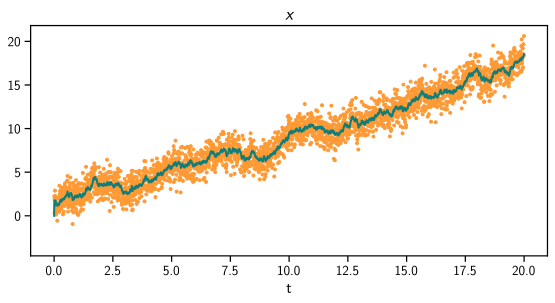

In [29]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(time_grid, posterior_state_means);

# Plot marginal standard deviations
std_x = np.sqrt(posterior_state_covs).squeeze()
ax.fill_between(time_grid, posterior_state_means - 1.96 * std_x,  posterior_state_means + 1.96 * std_x, alpha=0.2);

ax.scatter(time_grid[1:], observations, marker=".");

# Add labels etc.
ax.set_xlabel("t")

ax.set_title(r"$x$")

state_fig.tight_layout()